In [22]:
import torchvision.datasets as tv
from strategy import load_ndarrays_from_npz
from torch.utils.data import DataLoader, Subset,random_split,TensorDataset
import timm
import numpy as np
from data import transform_dict
from models.ViT import LiGOViT
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score
np.random.seed(42)
dataset_name = "CIFAR100"
root = "./datasets"
# Transforms
transform_train = transform_dict[dataset_name + "_train"]
transform_test = transform_dict[dataset_name + "_test"]
# Load entire dataset
if dataset_name == "CIFAR100":
    full_train_set = tv.CIFAR100(
        root, train=True, download=False, transform=transform_train
    )
    global_test_set = tv.CIFAR100(
        root, train=False, download=False, transform=transform_test
    )

# Define sizes
num_clients = 4
public_data_size = 10000
client_data_size = (len(full_train_set) - public_data_size) // num_clients

# Shuffle indices
indices = list(range(len(full_train_set)))
np.random.shuffle(indices)

# Assign public data indices
public_indices = indices[:public_data_size]
public_data = Subset(full_train_set, public_indices)

# Assign client train sets
client_indices = indices[
    public_data_size : public_data_size + client_data_size * num_clients
]
client_indices_list = np.array_split(client_indices, num_clients)
client_datasets = [Subset(full_train_set, indices) for indices in client_indices_list]

In [16]:
# Parameters
model_params = {
    "patch_size": 16,
    "n_hiddens": 320,
    "n_layers": 4,
    "num_heads": 8,
    "target_hiddens": 384,
    "target_layers": 6,
    "target_heads": 8,
    "num_classes": 100,
}
pretrained_path = "ligo_noniid.npz"

def load_ligo_vit(
    model_params: dict[str, int],
    pretrained_path: str,
    pop_non_ligo_params: bool = False,
):
    ligo_vit = LiGOViT(**model_params)
    ndarrays = load_ndarrays_from_npz(pretrained_path)
    keys = ligo_vit.state_dict().keys()

    if not pop_non_ligo_params:
        state_dict = {k: torch.tensor(v) for k, v in zip(keys, ndarrays)}
    else:
        state_dict = {
            k: torch.tensor(v)
            for k, v in zip(keys, ndarrays)
            if "expansion_operator" in k
        }

    ligo_vit.load_state_dict(state_dict,strict=not pop_non_ligo_params)
    ligo_vit.expand_params()

    large_vit = timm.models.VisionTransformer(
        patch_size=model_params["patch_size"],
        embed_dim=model_params["target_hiddens"],
        mlp_ratio=1,
        depth=model_params["target_layers"],
        num_heads=model_params["target_heads"],
        num_classes=model_params["num_classes"],
    )
    large_vit.load_state_dict(ligo_vit.large_model.state_dict())
    return large_vit


global_large_model = load_ligo_vit(model_params, pretrained_path,True)

In [23]:
# Parameters
#   patch_size: 16
#   n_hiddens: 384
#   n_layers: 6
#   num_heads: 8
#   num_classes: 100
model_params = {
    "patch_size": 16,
    "n_hiddens": 384,
    "n_layers": 6,
    "num_heads": 8,
    "num_classes": 100,
}
pretrained_path = "fedavg_iid.npz"

def load_vit(
    model_params: dict[str, int],
    pretrained_path: str,
):
    ligo_vit = LiGOViT(**model_params)
    ndarrays = load_ndarrays_from_npz(pretrained_path)
    keys = ligo_vit.state_dict().keys()


    state_dict = {k: torch.tensor(v) for k, v in zip(keys, ndarrays)}


    ligo_vit.load_state_dict(state_dict,strict=True)

    
    return ligo_vit.small_model
global_large_model = load_vit(model_params, pretrained_path)

In [24]:
shadow_model = global_large_model  # Replace with actual initialization

In [18]:
def train_shadow_model(shadow_model, public_data_loader, criterion, optimizer, num_epochs=10,device="cuda:0"):
    shadow_model.train()
    shadow_model.to(device)
    for epoch in tqdm(range(num_epochs)):
        for images, labels in public_data_loader:
            images,labels = images.to(device),labels.to(device)
            outputs = shadow_model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    shadow_model.cpu()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(shadow_model.parameters(), lr=0.001)
public_data_loader = DataLoader(public_data, batch_size=64, shuffle=True)
train_shadow_model(shadow_model, public_data_loader, criterion, optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:14<00:00, 19.40s/it]


In [25]:
def generate_logits_with_labels(model, data_loader,device="cuda:0"):
    model.eval()
    model.to(device)
    logits_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in data_loader:
            images,labels = images.to(device),labels.to(device)
            logits = model(images)
            logits_list.append(logits)
            labels_list.append(labels)
    model.cpu()
    return torch.cat(logits_list, dim=0), torch.cat(labels_list, dim=0)

# Generate logits for "in" and "out" samples with labels
in_loader = DataLoader(client_datasets[0], batch_size=64, shuffle=False)
out_loader = DataLoader(global_test_set, batch_size=64, shuffle=False)

in_logits, in_labels = generate_logits_with_labels(shadow_model, in_loader)
out_logits, out_labels = generate_logits_with_labels(shadow_model, out_loader)

In [26]:
len(client_datasets[0]),len(global_test_set)

(10000, 10000)

Run 1/5
Epoch 1/5, Loss: 0.6030, Accuracy: 0.6653
Epoch 2/5, Loss: 0.5417, Accuracy: 0.7200
Epoch 3/5, Loss: 0.5193, Accuracy: 0.7379
Epoch 4/5, Loss: 0.5050, Accuracy: 0.7468
Epoch 5/5, Loss: 0.4964, Accuracy: 0.7549


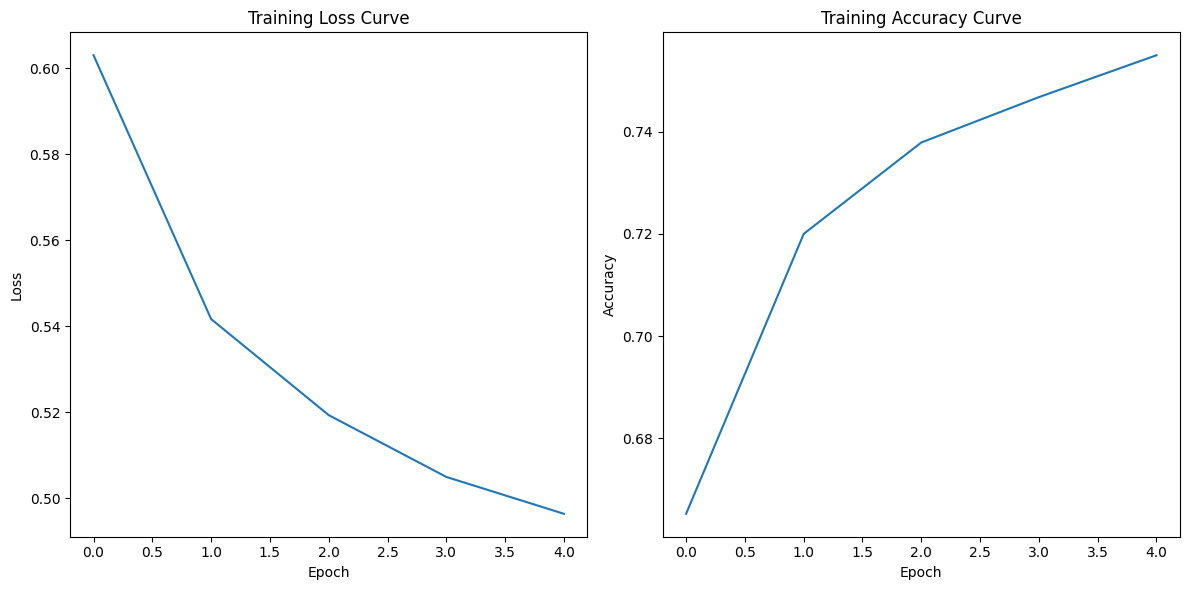

Acc: 0.729500, F1 Score: 0.721708, Precision: 0.744297, Recall: 0.700449
Run 2/5
Epoch 1/5, Loss: 0.5969, Accuracy: 0.6742
Epoch 2/5, Loss: 0.5380, Accuracy: 0.7224
Epoch 3/5, Loss: 0.5169, Accuracy: 0.7403
Epoch 4/5, Loss: 0.5005, Accuracy: 0.7501
Epoch 5/5, Loss: 0.4904, Accuracy: 0.7556


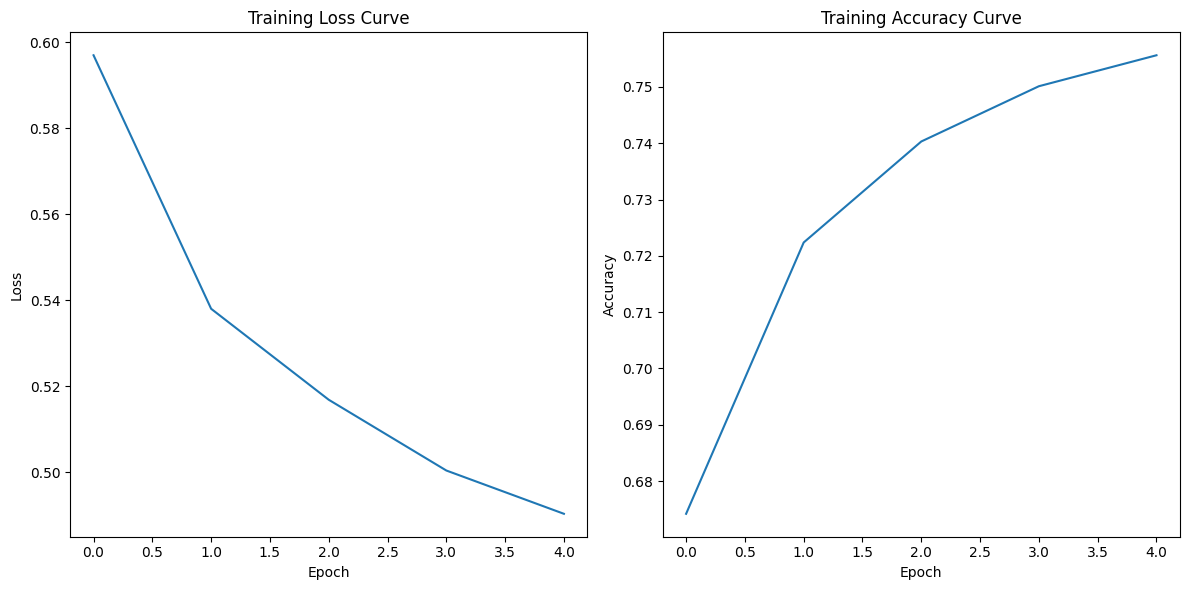

Acc: 0.729250, F1 Score: 0.701241, Precision: 0.783600, Recall: 0.634548
Run 3/5
Epoch 1/5, Loss: 0.5975, Accuracy: 0.6703
Epoch 2/5, Loss: 0.5382, Accuracy: 0.7167
Epoch 3/5, Loss: 0.5209, Accuracy: 0.7356
Epoch 4/5, Loss: 0.5061, Accuracy: 0.7449
Epoch 5/5, Loss: 0.4943, Accuracy: 0.7546


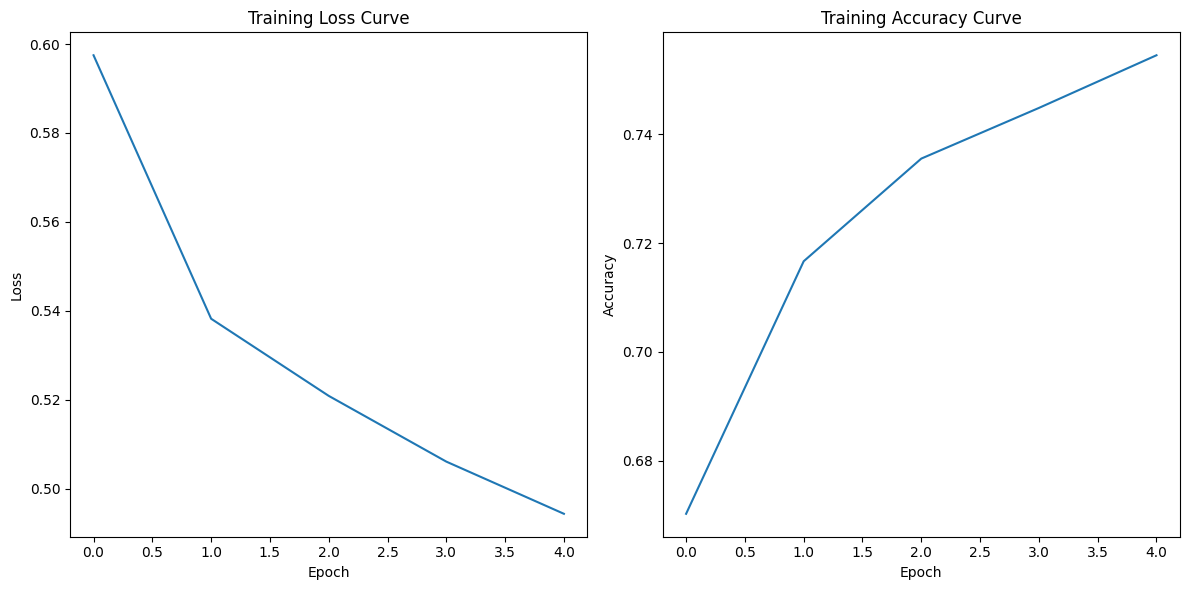

Acc: 0.726250, F1 Score: 0.705566, Precision: 0.764569, Recall: 0.655017
Run 4/5
Epoch 1/5, Loss: 0.5972, Accuracy: 0.6735
Epoch 2/5, Loss: 0.5383, Accuracy: 0.7216
Epoch 3/5, Loss: 0.5209, Accuracy: 0.7378
Epoch 4/5, Loss: 0.5054, Accuracy: 0.7467
Epoch 5/5, Loss: 0.4938, Accuracy: 0.7517


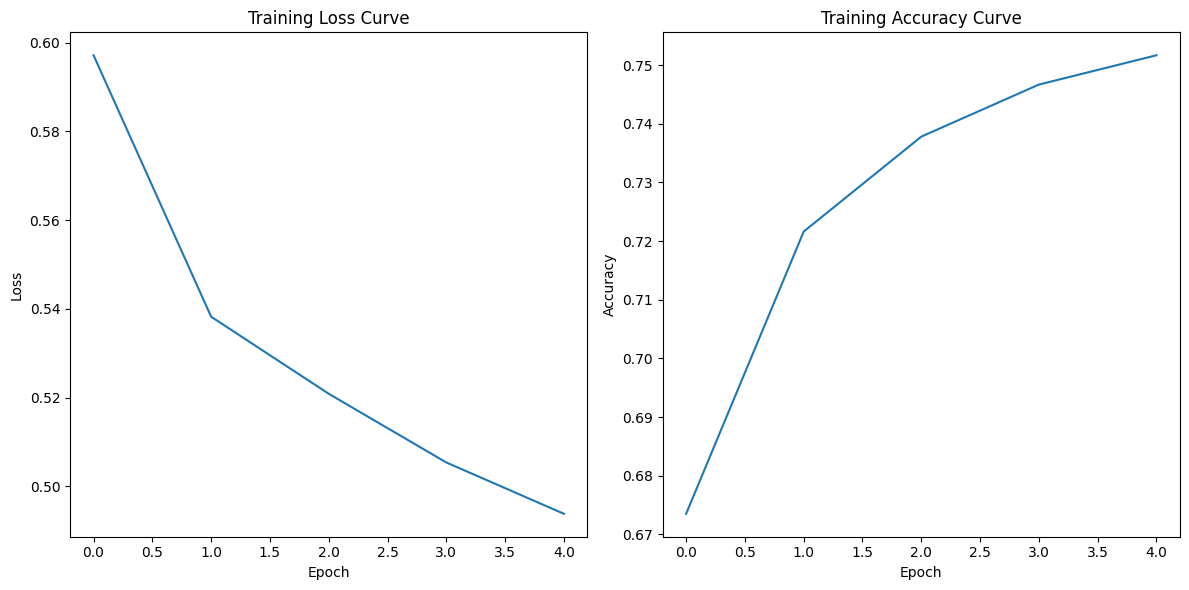

Acc: 0.736750, F1 Score: 0.727414, Precision: 0.755376, Recall: 0.701448
Run 5/5
Epoch 1/5, Loss: 0.5975, Accuracy: 0.6705
Epoch 2/5, Loss: 0.5405, Accuracy: 0.7211
Epoch 3/5, Loss: 0.5181, Accuracy: 0.7370
Epoch 4/5, Loss: 0.5026, Accuracy: 0.7468
Epoch 5/5, Loss: 0.4928, Accuracy: 0.7540


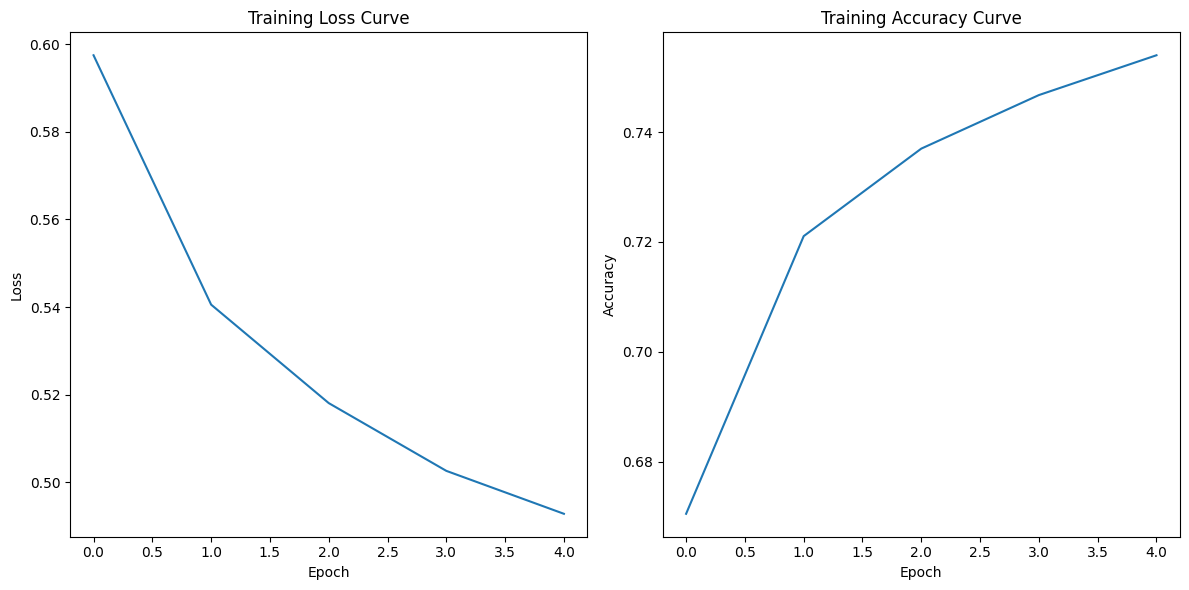

Acc: 0.723500, F1 Score: 0.701565, Precision: 0.763359, Recall: 0.649026
--------------------------------------------
Mean Metrics:
Acc: 72.9050 ± 0.4431
F1 Score: 71.1499 ± 1.0923
Precision: 76.2240 ± 1.2900
Recall: 66.8098 ± 2.7638


In [29]:
# Combine "in" and "out" logits and labels for MIA dataset
mia_features = torch.cat([in_logits, out_logits], dim=0)
mia_labels = torch.cat([torch.ones_like(in_labels), torch.zeros_like(out_labels)], dim=0)

# Create MIA dataset
mia_dataset = TensorDataset(mia_features, mia_labels)

# Define MIA classifier
mia_classifier = nn.Sequential(
    nn.Linear(shadow_model.num_classes, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Sigmoid()
)

# Split dataset into train and test sets
train_size = int(0.8 * len(mia_dataset))
test_size = len(mia_dataset) - train_size
train_dataset, test_dataset = random_split(mia_dataset, [train_size, test_size])

# Train MIA classifier
def train_mia_classifier(mia_classifier, train_dataset, num_epochs=5, device="cuda:0"):
    mia_classifier.train()
    mia_classifier.to(device)
    loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(mia_classifier.parameters(), lr=0.001)
    
    loss_history = []  # To store loss values for plotting
    accuracy_history = []  # To store accuracy values for plotting
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            predictions = mia_classifier(features)
            loss = criterion(predictions, labels.unsqueeze(1).float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            # Compute accuracy
            predicted_labels = (predictions >= 0.5).long().squeeze()
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)
        
        epoch_loss /= len(loader)
        loss_history.append(epoch_loss)
        
        accuracy = correct_predictions / total_predictions
        accuracy_history.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    mia_classifier.cpu()
    
    # Plot the loss curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    
    # Plot the accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Curve')
    
    plt.tight_layout()
    plt.show()

# Evaluate MIA classifier
def evaluate_mia_classifier(mia_classifier, test_dataset, device="cuda:0"):
    mia_classifier.eval()
    mia_classifier.to(device)
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            predictions = mia_classifier(features)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_predictions = [1 if p >= 0.5 else 0 for p in all_predictions]
    
    acc = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    
    return acc, f1, precision, recall

# Execute multiple runs to get mean and std of metrics
num_runs = 5
metrics = []

for run in range(num_runs):
    print(f"Run {run+1}/{num_runs}")
    mia_classifier = nn.Sequential(
        nn.Linear(shadow_model.num_classes, 100),
        nn.ReLU(),
        nn.Linear(100, 1),
        nn.Sigmoid()
    )
    
    train_mia_classifier(mia_classifier, train_dataset)
    acc, f1, precision, recall = evaluate_mia_classifier(mia_classifier, test_dataset)
    metrics.append((acc, f1, precision, recall))
    print(f"Acc: {acc:.6f}, F1 Score: {f1:.6f}, Precision: {precision:.6f}, Recall: {recall:.6f}")

# Calculate mean and std of metrics
metrics = np.array(metrics)
mean_metrics = np.mean(metrics, axis=0)*100
std_metrics = np.std(metrics, axis=0)*100
print("--------------------------------------------")
print("Mean Metrics:")
print(f"Acc: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
print(f"F1 Score: {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
print(f"Precision: {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")
print(f"Recall: {mean_metrics[3]:.4f} ± {std_metrics[3]:.4f}")

In [ ]:
import transformers

transformers.ViTForImageClassification